### 1. Using two different Scikit algorithms implementations, perform image segmantation in the Lab and RGB image space. Compare the results.

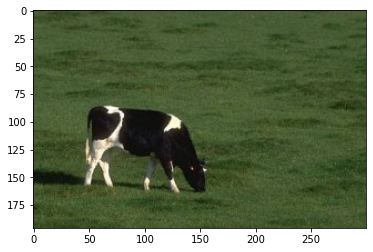

In [13]:
import cv2 as cv
import matplotlib.pyplot as plt

cow = cv.imread("cow.jpg")
rgb_cow = cv.cvtColor(cow, cv.COLOR_BGR2RGB)
lab_cow = cv.cvtColor(cow, cv.COLOR_BGR2Lab)
gray_cow = cv.cvtColor(cow, cv.COLOR_BGR2GRAY)
plt.imshow(rgb_cow)


c:\users\georges\documents\facultate\master\an1\s2\uaic_fii_cv\pythonproject\venv\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


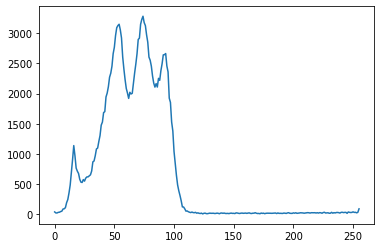

In [15]:
from skimage.exposure import histogram
hist, hist_centers = histogram(rgb_cow)
plt.plot(hist)

c:\users\georges\documents\facultate\master\an1\s2\uaic_fii_cv\pythonproject\venv\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


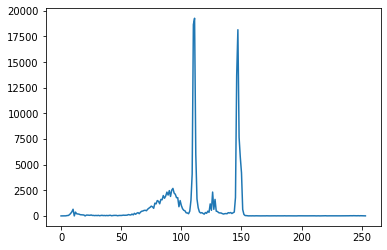

In [16]:
hist, hist_centers = histogram(lab_cow)
plt.plot(hist)

* The histograms for the 2 color spaces are different.
* The RGB color space has a big amount of values between 50 and 100
* The Lab color space has two huge spikes around 110 and 150

* Region-based segmentation

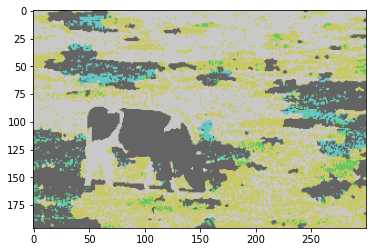

In [23]:
from skimage.segmentation import watershed
from skimage.filters import sobel
import numpy as np

cow_markers = np.zeros_like(rgb_cow)
cow_markers[rgb_cow < 50] = 100
cow_markers[rgb_cow > 90] = 200
cow_elevation_map = sobel(rgb_cow)
segmentation = watershed(cow_elevation_map, cow_markers)
plt.imshow(segmentation)

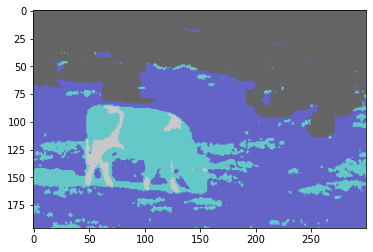

In [24]:
cow_markers = np.zeros_like(lab_cow)
cow_markers[lab_cow < 100] = 100
cow_markers[lab_cow > 150] = 200
cow_elevation_map = sobel(lab_cow)
segmentation = watershed(cow_elevation_map, cow_markers)
plt.imshow(segmentation)

* Canny Edge detector

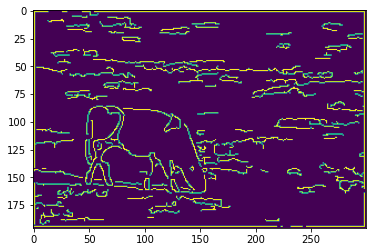

In [29]:
from skimage.feature import canny

edges = canny(gray_cow/255.)
plt.imshow(edges)

### 2. Use the KDTree, as explained in w4, to speed up the Mean Shift algorithm. Compare the runtime against the resolution of the input image.

In [ ]:

def find_peak(img, x1, r):
  """
  # this function is going to receive the vectorized Lab image
  # the value of the pixel labeled
  # the radius for the ball in Lab space used for MeanShift
  """
  old_mean = np.zeros((3, 1))
  new_mean = x1.astype(np.float32)
  num_samples = img.shape[1]
  iter = 0

  while np.linalg.norm(new_mean - old_mean) > 1e-5 and iter < 10:
    iter += 1

    distances = np.zeros(num_samples)
    for j in range(num_samples):
      distances[j] = np.linalg.norm(img[:, j] - new_mean)

    neighbors_idx = np.argwhere(distances < r)

    neighbors = img[:, neighbors_idx].squeeze(-1) # img should be 3xnum_samples
    if neighbors.shape[1] > 0:
      old_mean = new_mean
      new_mean = neighbors.mean(axis=1)
    else:
      break

  return new_mean


def mean_shift_segmentation(img, radius):
  h, w, _ = img.shape
  img = img.astype(np.float32)
  arr_img = np.zeros((3, h * w))
  k = 0

  for i in range(h):
    for j in range(w):
      arr_img[:, k] = img[i, j, :].astype(np.float32)
      k += 1

  # segmentation map
  map = np.zeros((h, w))
  peaks = np.zeros((3, h * w))
  k = 0
  for i in range(h):
    for j in range(w):

      peak = find_peak(arr_img, img[i, j, :], radius)
      already_in = 0

      # check the existing clusters before adding new ones
      if k > 0:
        for h in range(1, k+1):
          # check the balls corresponding to other clusters
          if np.linalg.norm(peak - peaks[:, h - 1]) < radius / 2:
            already_in = h
            break

        # check if the label was found
        if already_in == 0: # add a new label
          k += 1
          map[i, j] = k
          peaks[:, k - 1] = peak
          #print((i, j), k, peak)
        else:
          #print((i, j), already_in, peaks[:, already_in - 1])
          map[i, j] = already_in # use the found label

      else: # first cluster is to be logged
        k += 1
        map[i, j] = k
        peaks[:, k - 1] = peak
        #print((i, j), k, peak)


  peaks = peaks[:, :k]
  return map, peaks


def visualize_segmentation_map(map):
  plt.rcParams['figure.figsize'] = [8, 4]
  plt.rcParams['figure.dpi'] = 200

  h, w = map.shape
  max_colors = int(map.max())
  colors = [np.random.randint(0, 255, size=(3,)).astype(np.uint8) for _ in range(max_colors)]
  output_image = np.zeros((h, w, 3), dtype=np.uint8)

  for i in range(int(h)):
    for j in range(int(w)):
      output_image[i, j, :] = colors[int(map[i, j]) - 1]

  plt.imshow(output_image)

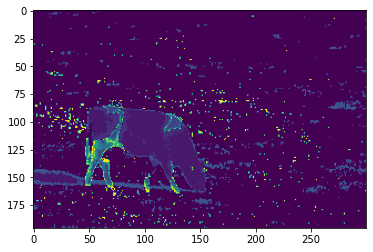

In [41]:
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

vectorized = np.float32(lab_cow.reshape((-1,3)))
bandwidth = estimate_bandwidth(vectorized, quantile=0.1, n_samples=100)
msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(vectorized)
result_image = np.reshape(msc.labels_, lab_cow.shape[:2])

plt.imshow(result_image)

### 3. Using numpy arrays and python provided data structures, implment the k-means clustering algorithm. Apply it as a segmentation method, in the Lab image space. Illustrate your results.

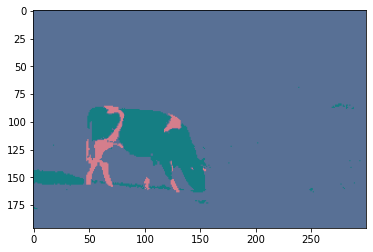

In [39]:
vectorized = np.float32(lab_cow.reshape((-1,3)))
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10
ret,label,center=cv.kmeans(vectorized,K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape(lab_cow.shape)
plt.imshow(result_image)


### 4. Using numpy arrays and python provided data structures, implment the DBSCAN clustering algorithm. Write a colab demo describing the algorithm, along with your implementation.

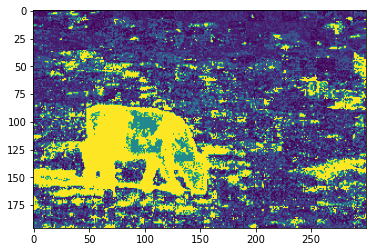

In [40]:
from sklearn.cluster import DBSCAN

db_img = np.float32(lab_cow.reshape((-1,3)))
db = DBSCAN(eps=0.3, min_samples=100).fit(db_img[:,:2])

plt.imshow(np.uint8(db.labels_.reshape(lab_cow.shape[:2])))
plt.show()

In [53]:
hist = np.array([2, 2, 2, 2, 0])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()

bins = np.arange(5)
fn_min = np.inf
thresh = -1
for i in range(1,(len(hist_norm))):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[4]-Q[i] # cum sum of classes
    if q1 < 1.e-6 or q2 < 1.e-6:
        continue
    b1,b2 = np.hsplit(bins,[i]) # weights
    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

print(thresh)

1
